In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [2]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
# keras.datasets 안에 boston_housing 데이터셋을 로드합니다.
(train_data_full, train_labels_full), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data_full, train_labels_full,
                                                             test_size = 0.25, random_state=9)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(6736,)
(2246,)
(2246,)


In [3]:
from tensorflow.keras import utils

# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, d in enumerate(data):
        results[i, d] = 1.
    return results

# 각 데이터셋에 대해 원-핫 인코딩 수행
x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터를 범주형 형태로 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)


(6736, 10000)
(2246, 10000)
(2246, 10000)
(2246, 46)


In [4]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
model = models.Sequential()
model.add(layers.Input(shape=(10000,), name='input'))
model.add(layers.Dense(128, activation="relu", name='hidden1'))
model.add(layers.BatchNormalization())
model.add(layers.Activation("selu"))
model.add(layers.Dropout(0.02))
model.add(layers.Dense(128, activation="relu", name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Activation("selu"))
model.add(layers.Dropout(0.02))
model.add(layers.Dense(46, activation="softmax", name='outputs'))


In [5]:
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

In [6]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
from tensorflow.keras import callbacks
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)
check_point_cb = callbacks.ModelCheckpoint('reuters_model.h5', 
                                           save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10, 
                                            monitor='val_loss',
                                            restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

(6736, 10000)
(2246, 10000)
(2246, 10000)
(2246, 46)
Epoch 1/60
211/211 [==============================] - 3s 8ms/step - loss: 1.3420 - accuracy: 0.7283 - val_loss: 1.1753 - val_accuracy: 0.7640
Epoch 2/60
211/211 [==============================] - 1s 5ms/step - loss: 0.5015 - accuracy: 0.8967 - val_loss: 0.9751 - val_accuracy: 0.7974
Epoch 3/60
211/211 [==============================] - 1s 5ms/step - loss: 0.2853 - accuracy: 0.9418 - val_loss: 1.1092 - val_accuracy: 0.8028
Epoch 4/60
211/211 [==============================] - 1s 5ms/step - loss: 0.2308 - accuracy: 0.9507 - val_loss: 1.0912 - val_accuracy: 0.8023
Epoch 5/60
211/211 [==============================] - 1s 5ms/step - loss: 0.1865 - accuracy: 0.9568 - val_loss: 1.1217 - val_accuracy: 0.8103
Epoch 6/60
211/211 [==============================] - 1s 5ms/step - loss: 0.1836 - accuracy: 0.9559 - val_loss: 1.1371 - val_accuracy: 0.8023
Epoch 7/60
211/211 [==============================] - 1s 6ms/step - loss: 0.1730 - accuracy: 0.

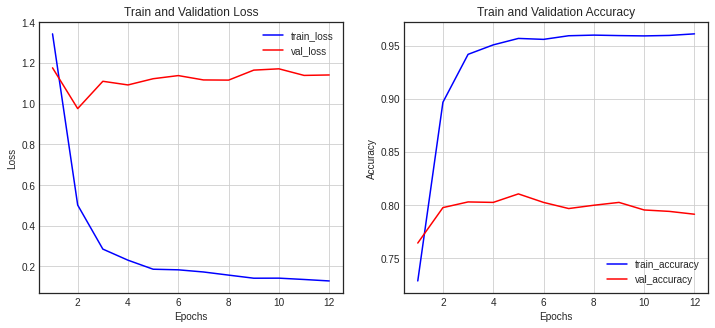

In [7]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [8]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 2ms/step - loss: 1.0031 - accuracy: 0.7912


[1.0031129121780396, 0.7911843061447144]